In [1]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
import numpy as np 
from torch.optim import Adam 
import matplotlib.pyplot as plt 
import torch

In [2]:
# generate noisy sine and cosine waves as toy data
def generate_wave_data(num_samples=1000, seq_length=100):
    t = np.linspace(0, 4*np.pi, seq_length)
    sine = np.sin(t) + 0.1 * np.random.randn(seq_length)
    cosine = np.cos(t) + 0.1 * np.random.randn(seq_length)

    data = np.stack([sine, cosine], axis=1)


    return data

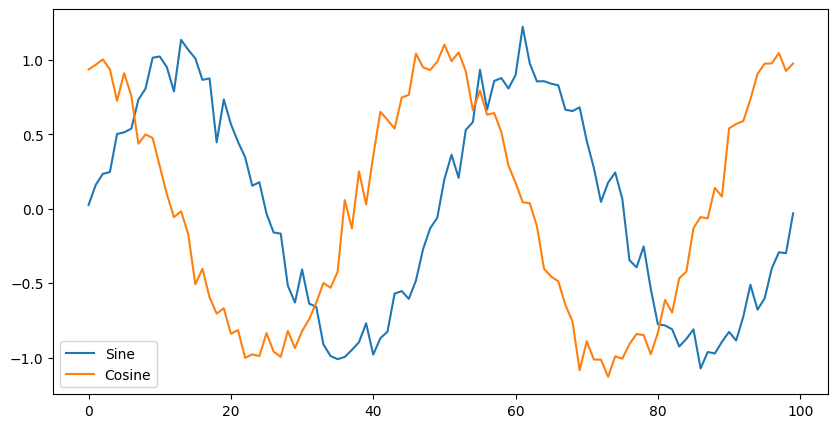

In [3]:
# plot the toy data 
data = generate_wave_data()

plt.figure(figsize=(10, 5))
plt.plot(data[:, 0], label="Sine")
plt.plot(data[:, 1], label="Cosine")
plt.legend()
plt.show()

In [4]:
# divide in past and future values for training the transformer 
past_values = torch.tensor(data[:-10], dtype=torch.float32)
future_values = torch.tensor(data[-10:], dtype=torch.float32)

In [5]:
# define the configuration of the model 
config = TimeSeriesTransformerConfig(
    prediction_length=10,  # length of the future values to predict
    context_length=89,  # length of the past values to use
    num_time_features=1,
    #num_dynamic_real_features=2,  # the number of time features (here we have only time steps)
    encoder_layers=2,  # number of transformer layers in the encoder
    decoder_layers=2,  # number of transformer layers in the decoder
    d_model=32,  # dimension of the model
    n_heads=4,  # number of attention heads
    input_size=2,
    lags_sequence=[1], 
    )

# initialize the model 
model = TimeSeriesTransformerForPrediction(config)

In [6]:
# Modified batch with correct dimensions
batch = {
    "past_values": past_values.unsqueeze(0),  # (1, seq_length, 2)
    "future_values": future_values.unsqueeze(0),  # (1, prediction_length, 2)
    "past_time_features": torch.arange(len(past_values)).unsqueeze(0).unsqueeze(2).float(),  # (1, seq_length, 1)
    "past_observed_mask": torch.ones_like(past_values).unsqueeze(0),  # (1, seq_length, 2)
    "future_time_features": torch.arange(len(past_values), len(past_values) + 10).unsqueeze(0).unsqueeze(2).float(),  # (1, prediction_length, 1)
}


In [7]:
# Initialize optimizer
optim = Adam(model.parameters(), lr=1e-3)

# Define training loop 
num_epochs = 100 

for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(
        past_values=batch["past_values"],
        past_time_features=batch["past_time_features"],
        past_observed_mask=batch["past_observed_mask"],
        future_values=batch["future_values"],
        future_time_features=batch["future_time_features"],
    )

    loss = outputs.loss

    # Backward pass
    optim.zero_grad()
    loss.backward()
    optim.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/100, Loss: 2.4111
Epoch 2/100, Loss: 2.2871
Epoch 3/100, Loss: 2.1824
Epoch 4/100, Loss: 2.0609
Epoch 5/100, Loss: 2.0372
Epoch 6/100, Loss: 1.8844
Epoch 7/100, Loss: 1.7953
Epoch 8/100, Loss: 1.7077
Epoch 9/100, Loss: 1.6501
Epoch 10/100, Loss: 1.5694
Epoch 11/100, Loss: 1.5167
Epoch 12/100, Loss: 1.5109
Epoch 13/100, Loss: 1.3968
Epoch 14/100, Loss: 1.3506
Epoch 15/100, Loss: 1.2916
Epoch 16/100, Loss: 1.2550
Epoch 17/100, Loss: 1.1907
Epoch 18/100, Loss: 1.1497
Epoch 19/100, Loss: 1.1117
Epoch 20/100, Loss: 1.0982
Epoch 21/100, Loss: 1.0102
Epoch 22/100, Loss: 0.9769
Epoch 23/100, Loss: 0.9391
Epoch 24/100, Loss: 0.8835
Epoch 25/100, Loss: 0.8376
Epoch 26/100, Loss: 0.8089
Epoch 27/100, Loss: 0.7512
Epoch 28/100, Loss: 0.7207
Epoch 29/100, Loss: 0.6903
Epoch 30/100, Loss: 0.6411
Epoch 31/100, Loss: 0.6130
Epoch 32/100, Loss: 0.5739
Epoch 33/100, Loss: 0.5594
Epoch 34/100, Loss: 0.5455
Epoch 35/100, Loss: 0.4982
Epoch 36/100, Loss: 0.4683
Epoch 37/100, Loss: 0.4399
Epoch 38/1

In [10]:
# evaluate the model 
model.eval()

with torch.no_grad():
    predictions=model.generate(
        past_values=batch["past_values"],
        past_time_features=batch["past_time_features"],
        future_time_features=batch["future_time_features"]
    )


# remove batch dimension of predictions 
predicted_values = predictions.sequences.squeeze(0).numpy()

In [12]:
predicted_values.shape

(100, 10, 2)

ValueError: x and y must have same first dimension, but have shapes (10,) and (100, 2)

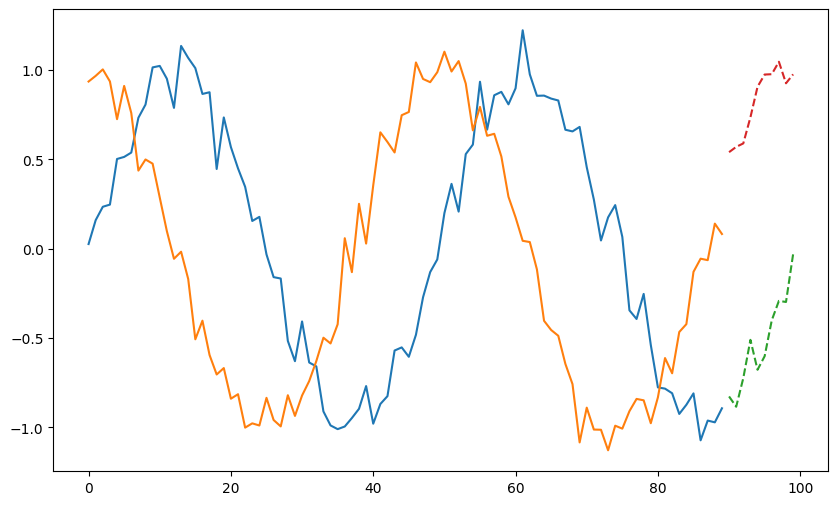

In [11]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot past values
plt.plot(np.arange(len(past_values)), past_values.numpy()[:, 0], label="Past Sine Values")
plt.plot(np.arange(len(past_values)), past_values.numpy()[:, 1], label="Past Cosine Values")

# Plot true future values
plt.plot(np.arange(len(past_values), len(past_values) + 10), future_values.numpy()[:, 0], label="True Future Sine Values", linestyle='dashed')
plt.plot(np.arange(len(past_values), len(past_values) + 10), future_values.numpy()[:, 1], label="True Future Cosine Values", linestyle='dashed')

# Plot predicted future values
plt.plot(np.arange(len(past_values), len(past_values) + 10), predicted_values[:, 0], label="Predicted Sine Values", linestyle='dotted')
plt.plot(np.arange(len(past_values), len(past_values) + 10), predicted_values[:, 1], label="Predicted Cosine Values", linestyle='dotted')

plt.legend()
plt.show()
